In [98]:
from hipecta.data import ctaTelescope2Matrix
from hipecta import core
import numpy as np
import h5py
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset, ConcatDataset, sampler
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import hipecta.plots as plots
from torchvision import transforms, utils
import math
import time
import os
import sys

converter_path = os.path.abspath(os.path.join('/home/jacquemont/GammaLearn/converter_hdf5'))
if converter_path not in sys.path:
    sys.path.append(converter_path)
    
from converter_hdf5 import *
from datasets import *

In [99]:
class CNNModelLST(nn.Module):
    def __init__(self):
        super(CNNModelLST, self).__init__()
        # conv1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        # non-linearity
        self.relu1 = nn.ReLU()
        # maxpooling 1, by default floor
        self.maxpool1 = nn.MaxPool2d(kernel_size=2) # nn.AvgPool2d
        # batch norm
        self.batchnorm1 = nn.BatchNorm2d(16)
        
        # conv2
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        # non-linearity
        self.relu2 = nn.ReLU()
        # maxpooling 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        # batch norm
        self.batchnorm2 = nn.BatchNorm2d(32)
        
        # conv3
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        # non-linearity
        self.relu3 = nn.ReLU()
        # maxpooling 3
        self.maxpool3 = nn.MaxPool2d(kernel_size=2) # nn.AvgPool2d
        # batch norm
        self.batchnorm3 = nn.BatchNorm2d(64)
        
        # conv4
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        # non-linearity
        self.relu4 = nn.ReLU()
        # maxpooling 4
        self.maxpool4 = nn.MaxPool2d(kernel_size=2) # nn.AvgPool2d
        # batch norm
        self.batchnorm4 = nn.BatchNorm2d(128)
        
        # conv5
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=0)
        # non-linearity
        self.relu5 = nn.ReLU()
        
        # readout, regression of energy, altitude, azimuth, xCore, yCore
        #self.fc1 = nn.Linear(128, 5)
         # readout, regression of energy
        self.fc1 = nn.Linear(128, 1)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_uniform(m.weight.data, mode='fan_out')
                
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.maxpool1(out)
        out = self.batchnorm1(out)
        out = self.conv2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)
        out = self.batchnorm2(out)
        out = self.conv3(out)
        out = self.relu3(out)
        out = self.maxpool3(out)
        out = self.batchnorm3(out)
        out = self.conv4(out)
        out = self.relu4(out)
        out = self.maxpool4(out)
        out = self.batchnorm4(out)
        out = self.conv5(out)
        out = self.relu5(out)

        # Reshape out from 100,128,1 to 100,128
        out = out.view(out.size(0),-1)
        
        out = self.fc1(out)
        return out

In [101]:
test_file = '/home/jacquemont/projets_CTA/gamma0.hdf5'
f = h5py.File(test_file, 'r')
injTable = np.array(f['/Cameras/LSTCAM/injTable'])
nbRow = f['/Cameras/LSTCAM'].attrs['nbRow']
nbCol = f['/Cameras/LSTCAM'].attrs['nbCol']
test_dataset = LSTCamDataset(hdf5_file=f,
                             transform=transforms.Compose([
                                 TelescopeToSquareMatrix(injTable, nbRow, nbCol),
                                 ToTensor()
                             ]))

test_dataset_2 = LSTCamDataset(hdf5_file=f)

test_dataset_3 = ConcatDataset([test_dataset, test_dataset_2])


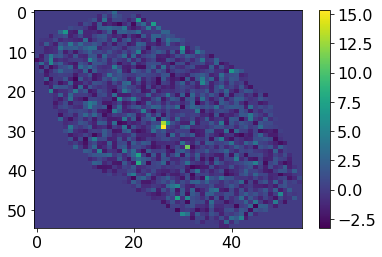

In [102]:
sample = test_dataset[4833]
plots.plotmatrix(sample['image'][0].numpy())

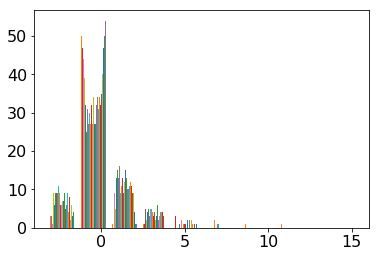

In [103]:
plt.hist(sample['image'][0].numpy())
plt.show()


In [104]:
# Creation of subset train and test
random_indices = torch.randperm(len(test_dataset))
train_max_index = int(len(test_dataset)*0.9)
train_set_sampler = sampler.SubsetRandomSampler(random_indices[0:train_max_index])
test_set_sampler = sampler.SubsetRandomSampler(random_indices[train_max_index + 1:])

batch_size = 16
n_iters = 6000
num_epochs = int(n_iters/(len(test_dataset)*0.9/batch_size))
print(num_epochs)

# iterable subset creation
train_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=batch_size,
                                           sampler=train_set_sampler)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          sampler=test_set_sampler)

10


In [105]:
if torch.cuda.is_available():
    print("CUDA available")

CUDA available


In [90]:
model = CNNModelLST()
model.double()
onGPU = True

## Run on GPU ##
if torch.cuda.is_available() and onGPU:
    print('model on GPU')
    model.cuda()

criterion = nn.MSELoss()

learning_rate = 0.001

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

#scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)
loss_epoch = []
itera = 0
time_1 = time.time()
gpu_time = 0
for epoch in range(num_epochs):
    
    for i, samples in enumerate(train_loader):

        ## Run on GPU ##
        if torch.cuda.is_available() and onGPU:
            #Load data as variable
            images = Variable(samples['image'].cuda())
            labels = Variable(samples['labels'].cuda())
        else:
            images = Variable(samples['image'])
            labels = Variable(samples['labels'])
        
        time_g = time.time()
        # clear gradient wrt parameters
        optimizer.zero_grad()
    
        # forward pass
        outputs = model(images)
    
        # claculate loss
        loss = criterion(outputs, labels)
    
        # backward pass
        loss.backward()
        loss_epoch[epoch] = loss.data[0]
        # update parameters
        optimizer.step()
        
    
        gpu_time += (time.time() - time_g)
        
        itera +=1
    
        if itera%100==0:    
            print('Epoch {} Iteration {} Training Loss {} '.format(epoch, itera, loss.data[0]))
            #print(model.state_dict()['conv1.weight'][0])
    
    energy = np.empty((0, 1), np.double)
    energy_inferred = np.empty((0, 1), np.double)
    for i, samples in enumerate(test_loader):

        ## Run on GPU ##
        if torch.cuda.is_available() and onGPU:
            #Load data as variable
            images = Variable(samples['image'].cuda())
            labels = Variable(samples['labels'].cuda())
        else:
            images = Variable(samples['image'])
            labels = Variable(samples['labels'])

        # forward pass
        outputs = model(images)
        energy = np.append(energy, labels.data[:,0].cpu().numpy())
        energy_inferred = np.append(energy_inferred, outputs.data[:,0].cpu().numpy())
    
    loss_epoch.append(np.mean((energy - energy_inferred)**2))
    print('Epoch {} Test Loss {} '.format(epoch, loss_epoch[epoch]))
    
ratio_gpu = gpu_time / (time.time() - time_1)
print('Ratio of gpu time : ', ratio_gpu)

model on GPU
Epoch 0 Iteration 100 Training Loss 8.093695272745146 

(0 ,.,.) = 
 -0.0531  0.0118  0.1214
 -0.0076 -0.1560  0.1809
  0.1612 -0.2063  0.1712
[torch.cuda.DoubleTensor of size 1x3x3 (GPU 0)]

Epoch 0 Iteration 200 Training Loss 0.07463164301200997 

(0 ,.,.) = 
  0.1152  0.1485  0.2185
  0.0155 -0.1252  0.1856
  0.1956 -0.1871  0.1395
[torch.cuda.DoubleTensor of size 1x3x3 (GPU 0)]

Epoch 0 Iteration 300 Training Loss 1.1269128876762726 

(0 ,.,.) = 
  0.1166  0.1416  0.2323
  0.0189 -0.1243  0.1797
  0.1964 -0.1885  0.1309
[torch.cuda.DoubleTensor of size 1x3x3 (GPU 0)]

Epoch 0 Iteration 400 Training Loss 0.2597942095437012 

(0 ,.,.) = 
  0.1148  0.1507  0.2284
  0.0219 -0.1272  0.1757
  0.1949 -0.1942  0.1273
[torch.cuda.DoubleTensor of size 1x3x3 (GPU 0)]

Epoch 0 Iteration 500 Training Loss 0.1406741363222856 

(0 ,.,.) = 
  0.1171  0.2381  0.2322
  0.0742 -0.0711  0.1314
  0.1722 -0.2118  0.1568
[torch.cuda.DoubleTensor of size 1x3x3 (GPU 0)]

Epoch 1 Iteration 600 

Epoch 7 Iteration 4400 Training Loss 3.9472159660726835 

(0 ,.,.) = 
 -0.5242 -0.0952 -0.5712
 -0.4085 -0.2128 -0.6682
 -0.2056 -0.4926  0.0407
[torch.cuda.DoubleTensor of size 1x3x3 (GPU 0)]

Epoch 7 Iteration 4500 Training Loss 0.7176950554432634 

(0 ,.,.) = 
 -0.5261 -0.0960 -0.5691
 -0.4096 -0.2173 -0.6676
 -0.2041 -0.4912  0.0410
[torch.cuda.DoubleTensor of size 1x3x3 (GPU 0)]

Epoch 8 Iteration 4600 Training Loss 0.05923998388004135 

(0 ,.,.) = 
 -0.5235 -0.0901 -0.5719
 -0.4080 -0.2081 -0.6700
 -0.2085 -0.4918  0.0530
[torch.cuda.DoubleTensor of size 1x3x3 (GPU 0)]

Epoch 8 Iteration 4700 Training Loss 0.32720079024496196 

(0 ,.,.) = 
 -0.5252 -0.0875 -0.5724
 -0.4080 -0.2053 -0.6706
 -0.2093 -0.4902  0.0512
[torch.cuda.DoubleTensor of size 1x3x3 (GPU 0)]

Epoch 8 Iteration 4800 Training Loss 1.6062713217470255 

(0 ,.,.) = 
 -0.5293 -0.0892 -0.5712
 -0.4079 -0.2024 -0.6687
 -0.2070 -0.4919  0.0509
[torch.cuda.DoubleTensor of size 1x3x3 (GPU 0)]

Epoch 8 Iteration 4900 Train

In [93]:
model.eval()
energy = np.empty((0, 1), np.double)
energy_inferred = np.empty((0, 1), np.double)
for i, samples in enumerate(test_loader):

    ## Run on GPU ##
    if torch.cuda.is_available() and onGPU:
        #Load data as variable
        images = Variable(samples['image'].cuda())
        labels = Variable(samples['labels'].cuda())
    else:
        images = Variable(samples['image'])
        labels = Variable(samples['labels'])

   
    # forward pass
    outputs = model(images)

    energy = np.append(energy, labels.data[:,0].cpu().numpy())
    energy_inferred = np.append(energy_inferred, outputs.data[:,0].cpu().numpy())

In [92]:
torch.save({'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'loss_epoch': loss_epoch}, f='/home/jacquemont/model1_kaimin-uniform_batchnorm_lr0.001.tar')

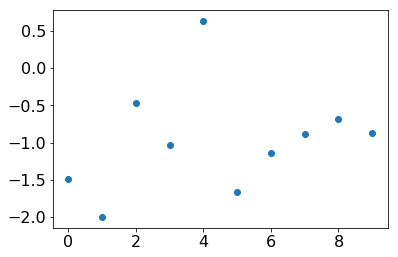

In [106]:
plt.scatter(range(num_epochs), [np.log10(l) for l in loss_epoch])
plt.show()

In [ ]:
loss_epoch

182.821151733
36.3680361069


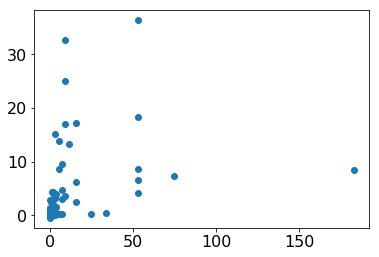

Test set mse :  45.754369807


In [96]:
print(energy.max())
print(energy_inferred.max())
plt.scatter(energy, energy_inferred)
plt.show()
mse = np.mean((energy - energy_inferred)**2)
print('Test set mse : ', mse)


In [ ]:
f.close()

In [ ]:
import torchvision.datasets as dsets
train_dataset = dsets.MNIST(root='./data',
                            train=True,
                            transform=transforms.ToTensor(),
                            download=True)

In [ ]:
train_dataset[0]

In [ ]:
a = np.zeros((5,5))
a.shape = (1,) + a.shape
a.shape